# Computing the oceanic kinetic energy flux across spatial scales using coarse-graining
by René Schubert and Willi Rath<br/>
GEOMAR Helmholtz-Centre for Ocean Research Kiel<br/>
rschubert@geomar.de

## Introduction
Here, we present a python package to compute the coarse-graining scale kinetic energy flux from 2D fields of zonal velocity component $u$ and meridional velocity component $v$. Following Leonard (1975) and Germano (1992), the flux of kinetic energy from currents associated with horizontal scales larger than a particular horizontal length scale $L$ to currents associated with scales smaller than $L$ is defined as:

$\Pi = -\rho_0[(\overline{u^2}-\overline{u}^2) \overline{u}_x + (\overline{uv}-\overline{u}\text{ }\overline{v})(\overline{u}_y + \overline{v}_x) + (\overline{v^2}-\overline{v}^2) \overline{v}_y]$

Here, $\rho$ is the standard density and $x$ is the zonal and $y$ the meridional Cartesian distance. Derivatives of $a$ with respect to $b$ are writtes as $\frac{\partial a}{\partial b} = a_b$. Overbars denote convolutions with a convolution kernel and thus low-pass filtered fields.

We follow Aluie et al. (2018) and use a top-hat convolution kernel consisting of a circular area of diameter $L$ with the value of the inverse of the circle's area and 0 elsewhere (The integral of the convolution kernel is 1). We compute $\Pi$ with two different variants:

- Variant 1: On the original grid
- Variant 2: On a regular metric grid, where $u$ and $v$ first have to be interpolated onto. 
    
Variant 1 is faster for small regions and small $L$. Variant 2 showed a better performance with respect to computational time and memory demand for large areas or large $L$. In particular, if the computations shall be executed for a range of scales $L$, saving the interpolated data and applying the analysis for each $L$ to it, is associated with a performance gain compared to the first variant (but also with the respective high storage demands). 

In [21]:
# choose L
scales = [10,50] # in kilometer

## 1. Load some 2D-fields of $u$ and $v$ and interpolate them onto the same grid (if necessary) 
The following code can be applied to any gapless $u$ and $v$ fields at a specific depth.
If $u$ and $v$ are not available on the same grid, we suggest to interpolate them first onto the same grid. 

Here, we use exemplary a model snapshot of the 1/60° horizontal resolution NEMO simulation INALT60 (Schwarzkopf et al., 2019, Schubert et al., 2019).
INALT60 solves the primitive equations on a Arakawa C-Grid (Arakawa & Lamb, 1977) with geographical coordinates. The u-values are computed on the center of the eastern boundary of the grid cell (U-grid points) and the v-values on the center of the northern boundary (V-grid points). First, $u$ and $v$ are interpolated onto the centre of the grid cell (T-grid point).

In [22]:
# load necessary modules
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [23]:
ia,ib,ja,jb = 300,601,800,1101 # cut region

# load u and v and interpolate them onto the T-grid points
ds = xr.open_dataset('../data/processed/udata.nc')
u_org = ds.vozocrtx.isel(x=slice(ia,ib),y=slice(ja,jb)).squeeze()
u = (u_org.shift(x=1)+u_org)/2 # interpolation onto T-grid points

ds = xr.open_dataset('../data/processed/vdata.nc')
v_org = ds.vomecrty.isel(x=slice(ia,ib),y=slice(ja,jb)).squeeze()
latv = v_org.nav_lat
lonv = v_org.nav_lon
v = (v_org.shift(y=1)+v_org)/2 # interpolation onto T-grid points

# load coordinates of T-grid-points
lat = u_org.nav_lat
lon = v_org.nav_lon

# cut first row and first column, as the interpolation gives no values there  
u = u.isel(x=slice(1,None),y=slice(1,None))
v = v.isel(x=slice(1,None),y=slice(1,None))
lon = lon.isel(x=slice(1,None),y=slice(1,None))
lat = lat.isel(x=slice(1,None),y=slice(1,None))

## 3. Show the Effect of the Convolution

Here, we choose Variant 1 and apply the convolution on the original grid. For Variant 1 you need to know the grid spacing (gs) in kilometer. You can compute that from the geographical coordinates using for example the Haversine formula. However, for most models, you can load the grid-spacing directly from the mask file:

In [12]:
# load grid-spacing
ds = xr.open_dataset('../data/processed/gsdata.nc')
e1t = ds.e1t.isel(x=slice(ia+1,ib),y=slice(ja+1,jb)).squeeze() # load zonal extend of the grid-cell in m (which is in this case similar to the meridional extend)
gs = e1t / 1000 # convert into km

In [18]:
# convolute u and v
um = np.zeros((len(scales),u.shape[0],u.shape[1])) + np.nan
vm = np.zeros((len(scales),u.shape[0],u.shape[1])) + np.nan
counter = 0
for scale_tmp in scales:
    # create convolution kernel for each grid-cell
    radius = int( (scale_tmp / gs.min().compute() / 2 ).round()) # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing  
    window_size = 2 * radius + 1
    gsr = gs.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
    gsr_lat = gsr.cumsum("lat_window")
    gsr_lat -= gsr_lat.isel(lat_window=radius)
    gsr_lon = gsr.cumsum("lon_window")
    gsr_lon -= gsr_lon.isel(lon_window=radius)
    circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < scale_tmp / 2)
    Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])

    # convolute u
    uA  = gs ** 2 * u # multiplication with area
    uAr = uA.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
    um_tmp = ((uAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    um_tmp2 = np.zeros((um_tmp.shape)) + np.nan
    um_tmp2[radius:-radius,radius:-radius] = um_tmp[radius:-radius,radius:-radius]
    um[counter,:,:] = um_tmp2

    # convolute v
    vA  = gs ** 2 * v # multiplication with area
    vAr = vA.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
    vm_tmp = ((vAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    vm_tmp2 = np.zeros((vm_tmp.shape)) + np.nan
    vm_tmp2[radius:-radius,radius:-radius] = vm_tmp[radius:-radius,radius:-radius]
    vm[counter,:,:] = vm_tmp2

    counter+=1

<ipython-input-32-bdb8bbb32540>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon,lat,100 * vel,cmap='Blues_r',vmin=0,vmax=70)
<ipython-input-32-bdb8bbb32540>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon,lat,100 * velm,cmap='Blues_r',vmin=0,vmax=70)
<ipython-input-32-bdb8bbb32540>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the 

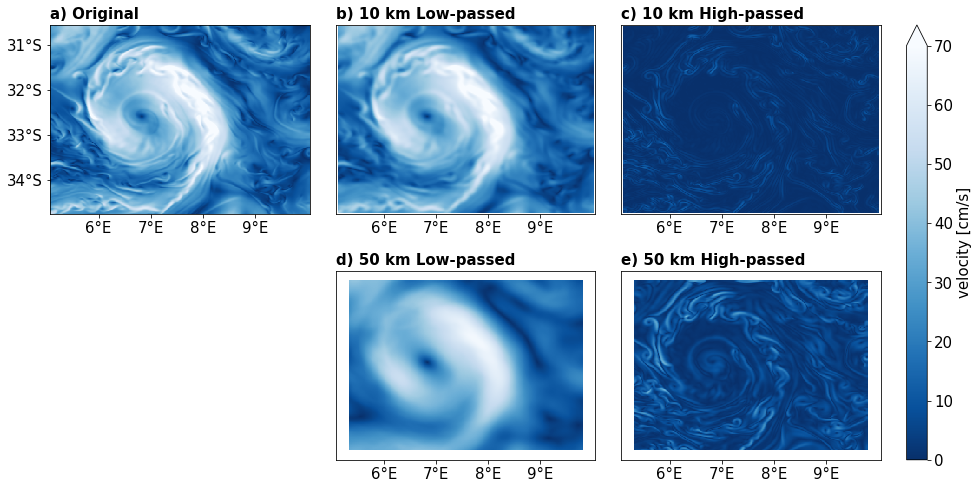

In [32]:
plt.figure(figsize=(20,8))
gc=plt.GridSpec(2,4) # rows, columns
gc.update(wspace=0.1, hspace=0.3)

def addplot():
    plt.xticks([6,7,8,9],['6°E','7°E','8°E','9°E'],fontsize=15)
    plt.yticks([-34,-33,-32,-31],['34°S','33°S','32°S','31°S'],fontsize=15)
    
# the velocity from the original components
vel = ( u ** 2 + v ** 2 ) ** 0.5
ax = plt.subplot(gc[0,0])
plt.pcolormesh(lon,lat,100 * vel,cmap='Blues_r',vmin=0,vmax=70)
plt.title('a) Original',fontsize=15,fontweight='bold',loc='left')
addplot()

# the velocity from the low-passed components
velm = ( um[0,:,:] ** 2 + vm[0,:,:] ** 2 ) ** 0.5 # compute the velocity for the low-passed fields
ax = plt.subplot(gc[0,1])
plt.pcolormesh(lon,lat,100 * velm,cmap='Blues_r',vmin=0,vmax=70)
plt.title('b) '+str(scales[0])+' km Low-passed',fontsize=15,fontweight='bold',loc='left')
ax.get_yaxis().set_visible(False)
addplot()

# the velocity from the high-passed componScaleents
veld = ( (u-um[0,:,:]) ** 2 + (v-vm[0,:,:]) ** 2 ) ** 0.5 # compute the velocity for the high-passed fields
ax = plt.subplot(gc[0,2])
cp = plt.pcolormesh(lon,lat,100 * veld,cmap='Blues_r',vmin=0,vmax=70)
plt.title('c) '+str(scales[0])+' km High-passed',fontsize=15,fontweight='bold',loc='left')
ax.get_yaxis().set_visible(False)
addplot()


# the velocity from the low-passed components
velm = ( um[1,:,:] ** 2 + vm[1,:,:] ** 2 ) ** 0.5 # compute the velocity for the low-passed fields
ax = plt.subplot(gc[1,1])
plt.pcolormesh(lon,lat,100 * velm,cmap='Blues_r',vmin=0,vmax=70)
plt.title('d) '+str(scales[1])+' km Low-passed',fontsize=15,fontweight='bold',loc='left')
ax.get_yaxis().set_visible(False)
addplot()

# the velocity from the high-passed componScaleents
veld = ( (u-um[1,:,:]) ** 2 + (v-vm[1,:,:]) ** 2 ) ** 0.5 # compute the velocity for the high-passed fields
ax = plt.subplot(gc[1,2])
cp = plt.pcolormesh(lon,lat,100 * veld,cmap='Blues_r',vmin=0,vmax=70)
plt.title('e) '+str(scales[1])+' km High-passed',fontsize=15,fontweight='bold',loc='left')
ax.get_yaxis().set_visible(False)
addplot()

ax = plt.subplot(gc[:,-1])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,fraction = 1,shrink=1,extend='max')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'velocity [cm/s]', fontsize = 15)

The effect of the convolution applied to the velocity components of a model snapshot from INALT60 showing submesoscale flows around an Agulhas ring. 


## 2. Compute and Show the Scale Kinetic Energy Flux $\Pi$

In [5]:
import keflux

In [29]:
%%time 
# Variant 1
pi_var1,lon_pi,lat_pi = keflux.comp_keflux(u,v,lon,lat,scales,'geographic',gs)

CPU times: user 4.52 s, sys: 1.23 s, total: 5.75 s
Wall time: 5.75 s


In [30]:
%%time
# Variant 2
pi_var2,x_pi,y_pi = keflux.comp_keflux(u,v,lon,lat,scales,'metric',1)

CPU times: user 15.6 s, sys: 808 ms, total: 16.4 s
Wall time: 15 s


<ipython-input-31-e114846aa124>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cp = plt.pcolormesh(lon,lat,1e6*pi_var1[0,:,:],cmap='seismic',vmin=-100,vmax=100)
<ipython-input-31-e114846aa124>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cp = plt.pcolormesh(lon,lat,1e6*pi_var1[1,:,:],cmap='seismic',vmin=-100,vmax=100)
<ipython-input-31-e114846aa124>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecat

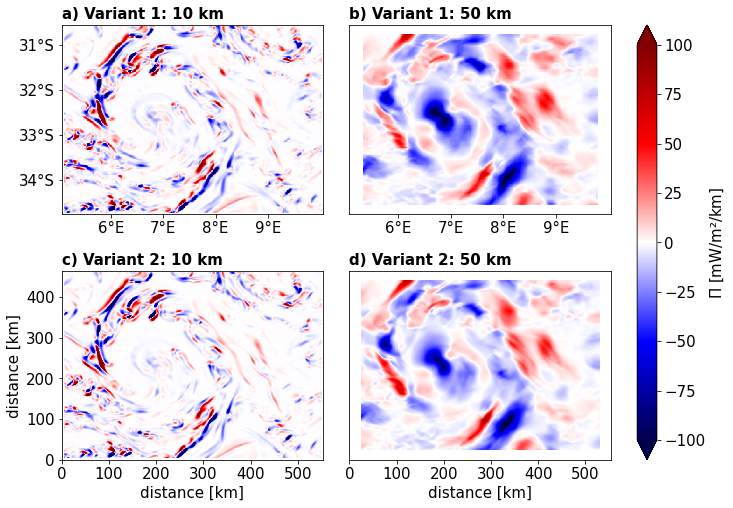

In [31]:
# show the scale kinetic energy flux in mW/m²/km
plt.figure(figsize=(15,8))
gc=plt.GridSpec(2,3) # rows, columns
gc.update(wspace=0.1, hspace=0.3)

ax = plt.subplot(gc[0,0])
cp = plt.pcolormesh(lon,lat,1e6*pi_var1[0,:,:],cmap='seismic',vmin=-100,vmax=100)
plt.title('a) Variant 1: '+str(scales[0])+' km',fontsize=15,fontweight='bold',loc='left')
addplot()

ax = plt.subplot(gc[0,1])
cp = plt.pcolormesh(lon,lat,1e6*pi_var1[1,:,:],cmap='seismic',vmin=-100,vmax=100)
plt.title('b) Variant 1: '+str(scales[1])+' km',fontsize=15,fontweight='bold',loc='left')
addplot()
ax.get_yaxis().set_visible(False)


ax = plt.subplot(gc[1,0])
cp = plt.pcolormesh(x_pi,y_pi,1e6*pi_var2[0,:,:],cmap='seismic',vmin=-100,vmax=100)
plt.title('c) Variant 2: '+str(scales[0])+' km',fontsize=15,fontweight='bold',loc='left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('distance [km]',fontsize=15)
plt.ylabel('distance [km]',fontsize=15)

ax = plt.subplot(gc[1,1])
cp = plt.pcolormesh(x_pi,y_pi,1e6*pi_var2[1,:,:],cmap='seismic',vmin=-100,vmax=100)
ax.get_yaxis().set_visible(False)
plt.title('d) Variant 2: '+str(scales[1])+' km',fontsize=15,fontweight='bold',loc='left')
plt.xticks(fontsize=15)
plt.xlabel('distance [km]',fontsize=15)

ax = plt.subplot(gc[:,-1])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,fraction = 1,shrink=1,extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\Pi$ [mW/m²/km]', fontsize = 15)

plt.tight_layout()

Negative values show upscale fluxes from smaller to larger horizontal scales; positive downscale fluxes.
In this case, submesoscale vortices are absorbed by the Agulhas ring transferring their energy upscale, but there occur also downscale fluxes, in particular in frontogenetic regions (see Schubert et al. (2020) for details.).

## References
Aluie, H., Hecht, M., & Vallis, G. K. (2018). Mapping the energy cascade in the North Atlantic Ocean: The coarse-graining approach. Journal of Physical Oceanography, 48(2), 225-244.

Arakawa, A., & Lamb, V. R. (1977). Computational design of the basic dynamical processes of the UCLA general circulation model. General circulation models of the atmosphere, 17(Supplement C), 173-265.

Germano, M. (1992). Turbulence- The filtering approach. Journal of Fluid Mechanics, 238(1), 325-336.

Leonard, A. (1975). Energy cascade in large-eddy simulations of turbulent fluid flows. In Advances in geophysics (Vol. 18, pp. 237-248). Elsevier.

Schubert, R., Schwarzkopf, F. U., Baschek, B., & Biastoch, A. (2019). Submesoscale impacts on mesoscale Agulhas dynamics. Journal of Advances in Modeling Earth Systems, 11(8), 2745-2767.

Schubert, R., Gula, J., Greatbatch, R. J., Baschek, B., & Biastoch, A. (2020). The submesoscale kinetic energy cascade: Mesoscale absorption of submesoscale mixed layer eddies and frontal downscale fluxes. Journal of Physical Oceanography, 50(9), 2573-2589.

Schwarzkopf, F. U., Biastoch, A., Böning, C. W., Chanut, J., Durgadoo, J. V., Getzlaff, K., ... & Schubert, R. (2019). The INALT family–a set of high-resolution nests for the Agulhas Current system within global NEMO ocean/sea-ice configurations. Geoscientific Model Development, 12(7), 3329-3355.